<a target="_blank" href="https://colab.research.google.com/github/ares2012/temp/blob/master/mbpp_advanced_analysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Comprehensive Analysis of MBPP Dataset

### Introduction

This notebook provides an in-depth analysis of the MBPP dataset.

In [1]:
! pip install radon --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 591.2 kB/s eta 0:00:00


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import radon.complexity as complexity
import radon.metrics as metrics
import radon.visitors as visitors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

file_path = 'mbpp.jsonl'
data = []
with open(file_path, 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

print("Dataset Information:")
print(df.info())
print("\nFirst few entries:")
print(df.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   text                 974 non-null    object
 1   code                 974 non-null    object
 2   task_id              974 non-null    int64 
 3   test_setup_code      974 non-null    object
 4   test_list            974 non-null    object
 5   challenge_test_list  974 non-null    object
dtypes: int64(1), object(5)
memory usage: 45.8+ KB
None

First few entries:
                                                text  \
0  Write a function to find the minimum cost path...   
1  Write a function to find the similar elements ...   
2  Write a python function to identify non-prime ...   
3  Write a function to find the largest integers ...   
4  Write a function to find the number of ways to...   

                                                code  task_id test_set

## Distribution of problem descriptions by length

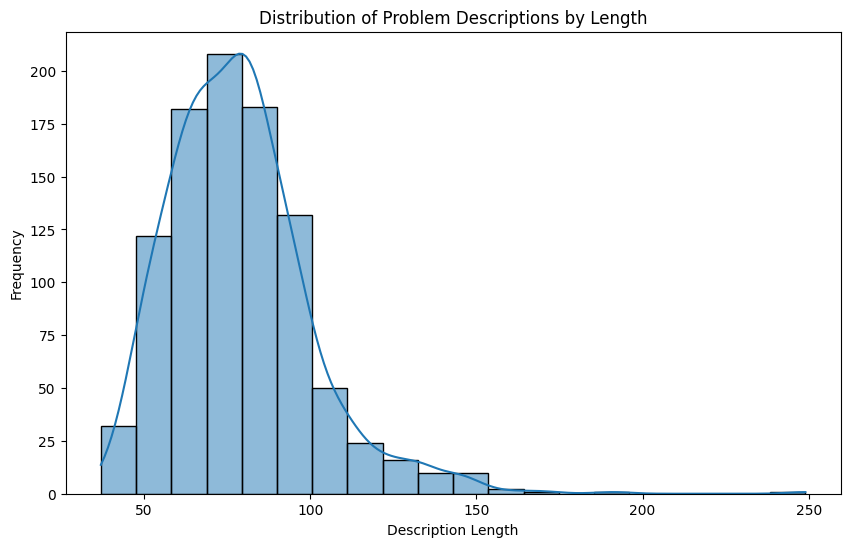

In [2]:
df['description_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], bins=20, kde=True)
plt.title('Distribution of Problem Descriptions by Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

## Distribution of code solutions by length

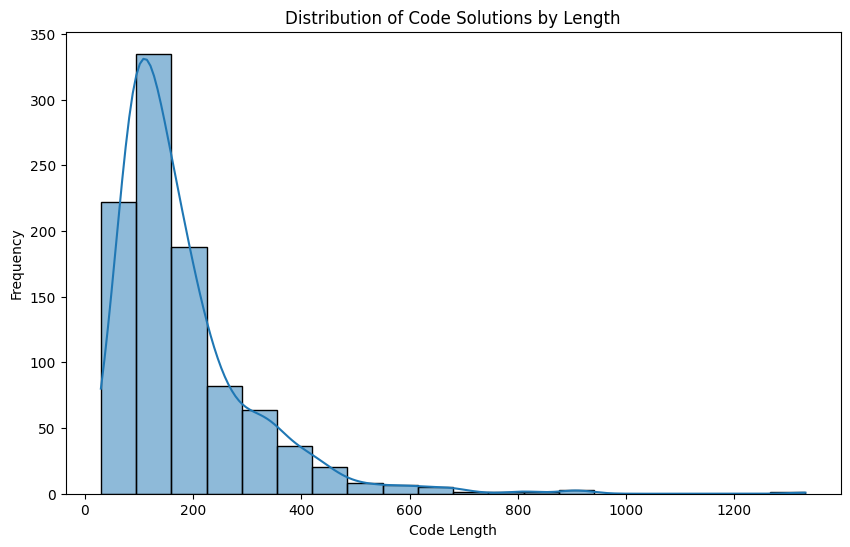

In [3]:
df['code_length'] = df['code'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['code_length'], bins=20, kde=True)
plt.title('Distribution of Code Solutions by Length')
plt.xlabel('Code Length')
plt.ylabel('Frequency')
plt.show()

## Common keywords in problem descriptions

In [80]:
import nltk, string
nltk.download('punkt_tab'); nltk.download('stopwords'); nltk.download('wordnet')

from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmar = WordNetLemmatizer()

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens if token.isalpha() and token not in english_stops]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

print(df['text'].apply(LemNormalize))
print(pd.Series([LemNormalize(document) for document in df['text']]))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0      [write, function, find, minimum, cost, path, r...
1      [write, function, find, similar, element, give...
2      [write, python, function, identify, nonprime, ...
3      [write, function, find, largest, integer, give...
4      [write, function, find, number, way, fill, x, ...
                             ...                        
969        [write, function, find, minimum, two, number]
970    [write, function, find, maximum, number, segme...
971    [write, function, concatenate, given, two, tup...
972      [write, python, function, left, rotate, string]
973    [write, function, find, minimum, total, path, ...
Name: text, Length: 974, dtype: object
0      [write, function, find, minimum, cost, path, r...
1      [write, function, find, similar, element, give...
2      [write, python, function, identify, nonprime, ...
3      [write, function, find, largest, integer, give...
4      [write, function, find, number, way, fill, x, ...
                             ...                 

In [5]:
import nltk, string
nltk.download('punkt_tab'); nltk.download('stopwords'); nltk.download('wordnet')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#tokenizer = RegexpTokenizer("\W+", gaps=True)
english_stops = set(stopwords.words('english'))

tf = df.copy()
#tf['tokenized'] = df['text'].apply(lambda x: [tokenizer.tokenize(doc) for doc in x])
tf['tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
tf['tokenized'] = tf['tokenized'].apply(lambda x: [char for char in x if char not in string.punctuation])
#tf['tokenized'] = df['text'].apply(lambda x: [word for word in x if word.lower() not in english_stops and len(word)>1])
tf['stop_words'] = tf['tokenized'].apply(lambda x: [word for word in x if word.lower() not in english_stops])


def my_tokenizer(docs):
    token_docs = docs.apply(lambda x: [nltk.word_tokenize(word) for word in x])
    #my_pos = [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective']]
    #return [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective'] and len(token)>1]
    return token_docs.apply(lambda x: [word for word in x if word.lower() not in english_stops])

def my_tokenizer(doc):
    token = nltk.word_tokenize(doc)
    token = [char for char in token if char not in string.punctuation]
    #my_pos = [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective']]
    #return [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective'] and len(token)>1]
    return [word for word in token if word.lower() not in english_stops]
    #return [word for word in token if word.lower() not in english_stops and len(word)>1]

print(tf['tokenized'])

0      [Write, a, function, to, find, the, minimum, c...
1      [Write, a, function, to, find, the, similar, e...
2      [Write, a, python, function, to, identify, non...
3      [Write, a, function, to, find, the, largest, i...
4      [Write, a, function, to, find, the, number, of...
                             ...                        
969    [Write, a, function, to, find, minimum, of, tw...
970    [Write, a, function, to, find, the, maximum, n...
971    [Write, a, function, to, concatenate, the, giv...
972    [Write, a, python, function, to, left, rotate,...
973    [Write, a, function, to, find, the, minimum, t...
Name: tokenized, Length: 974, dtype: object


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
from nltk import FreqDist
from nltk.util import ngrams

def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [my_tokenizer(document) for document in corpus]
    documents = corpus.apply(LemNormalize)
    #documents = [document for document in corpus]

    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]

    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    ngram_df = pd.DataFrame(top_freq, columns=["ngram", "count"])
    ngram_df['ngram']=ngram_df['ngram'].astype(str)
    #ngram_df["col"] = str(ngram)
    return ngram_df# Get frequent ngrams for all 4

'''
ngrams_df = DataFrame()
for i in range(1,5):
  ngrams_df = pd.concat([ngrams_df, get_frequent_ngram(csv_df['Article'], i)])
'''

"\nngrams_df = DataFrame()\nfor i in range(1,5):\n  ngrams_df = pd.concat([ngrams_df, get_frequent_ngram(csv_df['Article'], i)])\n"

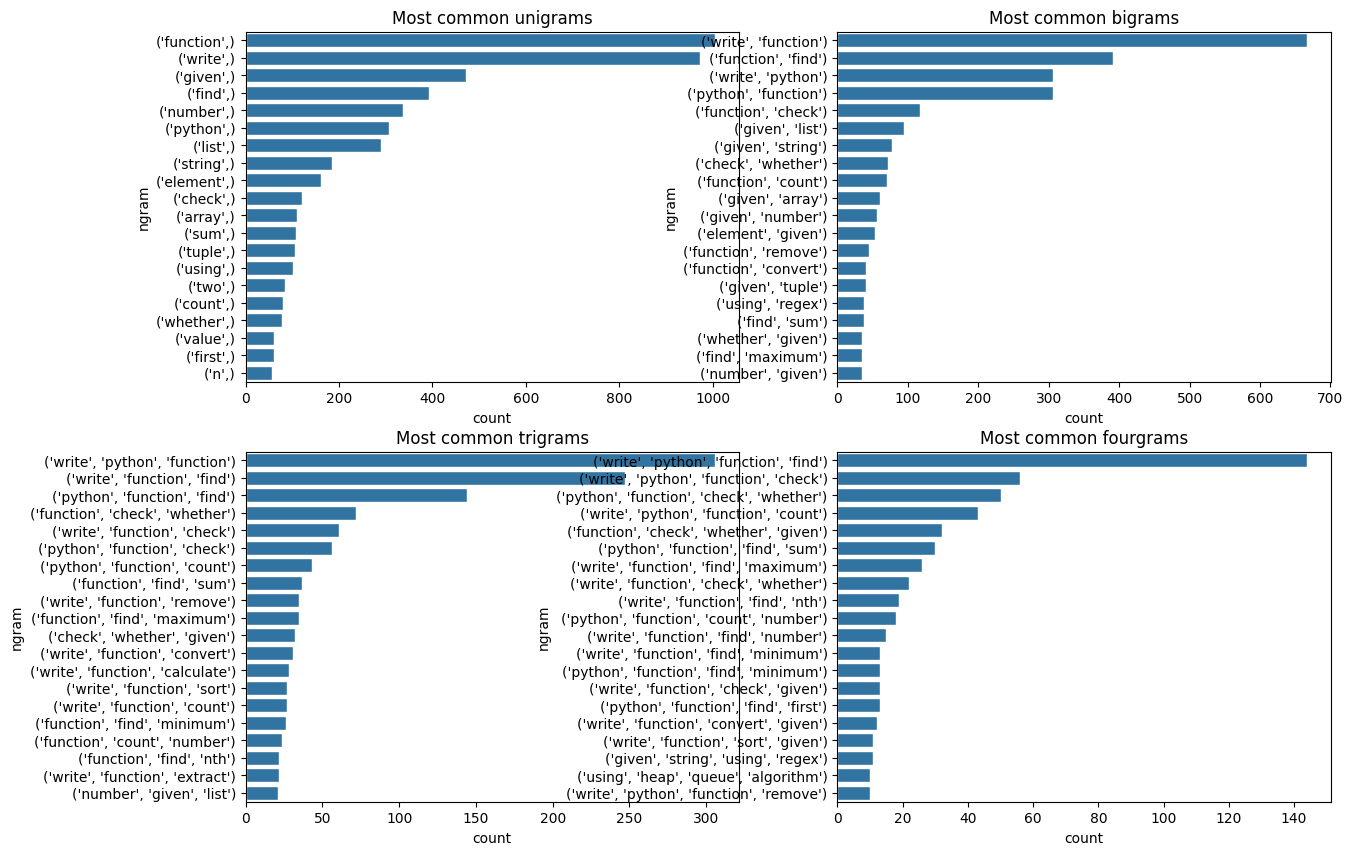

In [7]:
#plt.rcParams['font.family'] = 'NanumGothic'

fig, ax = plt.subplots(2,2, figsize=(14, 10))
mapping = {1:"uni", 2:"bi", 3:"tri", 4:"four"}
#sns.set_color_codes('pastel')
#sns.set_color_codes('muted')

for i in range(1,5):
    b = str(format(i-1,'b'))
    if len(b)<2:
        b='0'+b
    #ndf = get_frequent_ngram(tf['stop_words'], i)
    ndf = get_frequent_ngram(df['text'], i)
    sns.set_theme(style="whitegrid") ## figure, axes 스타일
    sns.barplot(x=ndf['count'], y=ndf['ngram'], ax=ax[int(b[0]), int(b[1])]).set(title=f"Most common {mapping[i]}grams")
    #sns.barplot(palette='Blues_r', edgecolor='w', x="count", y="ngram", data=get_frequent_ngram(csv_df['Article'], i), ax=ax[int(b[0]), int(b[1])]).set(title=f"Most common {mapping[i]}grams")
    plt.title(f"Most common {mapping[i]}grams")
#plt.savefig('article_ngram_token_pos.png')  # 필요한 경우, 그래프를 이미지 파일로 저장한다.
plt.show()

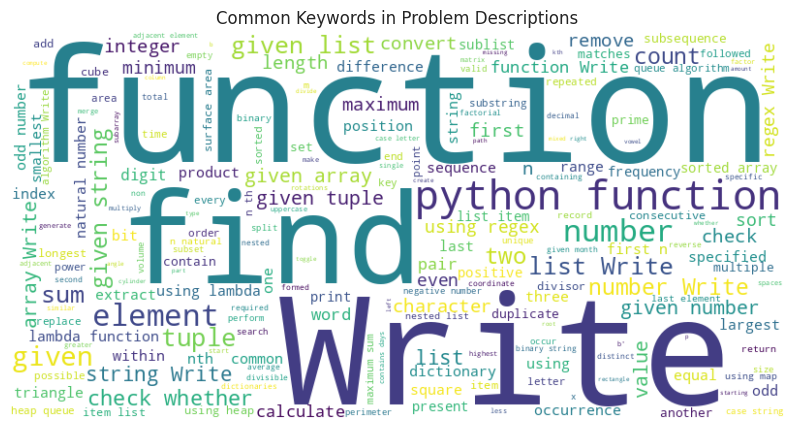

In [8]:
desc_text = " ".join(df['text'])
desc_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(desc_text)
plt.figure(figsize=(10, 6))
plt.imshow(desc_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Keywords in Problem Descriptions')
plt.show()

In [131]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# CountVectorizer를 사용하여 벡터화
#count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
count_vectorizer = CountVectorizer(tokenizer=LemNormalize, token_pattern=None)
count_vectors = count_vectorizer.fit_transform(df['text'])

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(tokenizer=LemNormalize, token_pattern=None)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['text'])

# 코사인 유사도 계산
cosine_sim_count = cosine_similarity(count_vectors, count_vectors)
cosine_sim_tfidf = cosine_similarity(tfidf_vectors, tfidf_vectors)

print("CountVectorizer를 사용한 코사인 유사도:", cosine_sim_count.shape)
print(cosine_sim_count)
print("\nTF-IDF를 사용한 코사인 유사도:", cosine_sim_tfidf.shape)
print(cosine_sim_tfidf)

CountVectorizer를 사용한 코사인 유사도: (974, 974)
[[1.         0.24759378 0.15161961 ... 0.19695965 0.15161961 0.37139068]
 [0.24759378 1.         0.27216553 ... 0.58925565 0.27216553 0.44444444]
 [0.15161961 0.27216553 1.         ... 0.28867513 0.5        0.27216553]
 ...
 [0.19695965 0.58925565 0.28867513 ... 1.         0.28867513 0.35355339]
 [0.15161961 0.27216553 0.5        ... 0.28867513 1.         0.27216553]
 [0.37139068 0.44444444 0.27216553 ... 0.35355339 0.27216553 1.        ]]

TF-IDF를 사용한 코사인 유사도: (974, 974)
[[1.         0.02960916 0.00574806 ... 0.01460256 0.00646586 0.17705879]
 [0.02960916 1.         0.02074061 ... 0.29523892 0.02333061 0.08300372]
 [0.00574806 0.02074061 1.         ... 0.01760451 0.06501151 0.01611361]
 ...
 [0.01460256 0.29523892 0.01760451 ... 1.         0.0198029  0.04093553]
 [0.00646586 0.02333061 0.06501151 ... 0.0198029  1.         0.01812581]
 [0.17705879 0.08300372 0.01611361 ... 0.04093553 0.01812581 1.        ]]


In [132]:
# 가장 유사한 문장의 인덱스 찾기
import numpy as np
threshold = 1.0000; top_k=15

# Set diagonal elements to -1 to exclude self-similarity
cosine_sim = cosine_sim_tfidf
np.fill_diagonal(cosine_sim, -1)
'''
print(cosine_sim_count[cosine_sim_count >= threshold].shape)
for i in range(cosine_sim_count.shape[0]):
    for j in range(cosine_sim_count.shape[1]):
        if cosine_sim_count[i, j] >= threshold:
            print(i, j, cosine_sim_count[i, j])
#cosine_sim_count[cosine_sim_count >= threshold] = -1
'''

# Find the indices of the maximum similarity
# np.unravel_index converts a flat index to a multi-dimensional index
max_indices = np.unravel_index(np.argmax(cosine_sim), cosine_sim.shape)
i, j = max_indices

print(f"가장 유사한 두 벡터의 인덱스: {i}, {j}")
print(f"해당 벡터: {df['text'][i]}, {df['text'][j]}")
print(f"코사인 유사도: {cosine_sim[i, j]:.4f}")

가장 유사한 두 벡터의 인덱스: 94, 456
해당 벡터: Write a python function to find the minimum length of sublist., Write a python function to find the sublist having minimum length.
코사인 유사도: 1.0000


In [133]:
# 상삼각행렬(중복 제거)만 추출
triu_indices = np.triu_indices_from(cosine_sim, k=1)
sim_scores = cosine_sim[triu_indices]

# threshold 이상인 쌍의 인덱스와 유사도 추출
valid_indices = np.where(sim_scores > -1)[0]
print((974*974-974)/2, valid_indices.shape)

# 유사도 내림차순 정렬 후 top-k 추출
sorted_idx = valid_indices[np.argsort(sim_scores[valid_indices])[::-1]]
top_k_idx = sorted_idx[:top_k]

vectorizer = tfidf_vectorizer
print(f"Top-{top_k} 유사도 쌍 (threshold={threshold}):")
for rank, idx in enumerate(top_k_idx, 1):
    i = triu_indices[0][idx]
    j = triu_indices[1][idx]
    print(f"{rank}. 인덱스: ({i}, {j}), 유사도: {cosine_sim[i, j]:.4f}, 벡터: {df['text'][i]}, {df['text'][j]}")
    print(f" 유사도: {cosine_similarity(vectorizer.fit_transform(df['code'][[i,j]])[0], vectorizer.fit_transform(df['code'][[i,j]])[1])}, 코드: {df['code'][i]}, {df['code'][j]}")


473851.0 (473851,)
Top-15 유사도 쌍 (threshold=1.0):
1. 인덱스: (816, 882), 유사도: 1.0000, 벡터: Write a function to find numbers divisible by m or n from a list of numbers using lambda function., Write a function to find numbers divisible by m and n from a list of numbers using lambda function.
 유사도: [[1.]], 코드: def div_of_nums(nums,m,n):
 result = list(filter(lambda x: (x % m == 0 or x % n == 0), nums)) 
 return result, def div_of_nums(nums,m,n):
 result = list(filter(lambda x: (x % m == 0 and x % n == 0), nums)) 
 return result
2. 인덱스: (94, 456), 유사도: 1.0000, 벡터: Write a python function to find the minimum length of sublist., Write a python function to find the sublist having minimum length.
 유사도: [[0.2523342]], 코드: def Find_Min_Length(lst):  
    minLength = min(len(x) for x in lst )
    return minLength , def Find_Min(lst): 
    minList = min((x) for x in lst) 
    return minList
3. 인덱스: (216, 601), 유사도: 1.0000, 벡터: Write a python function to find the first repeated character in a given stri

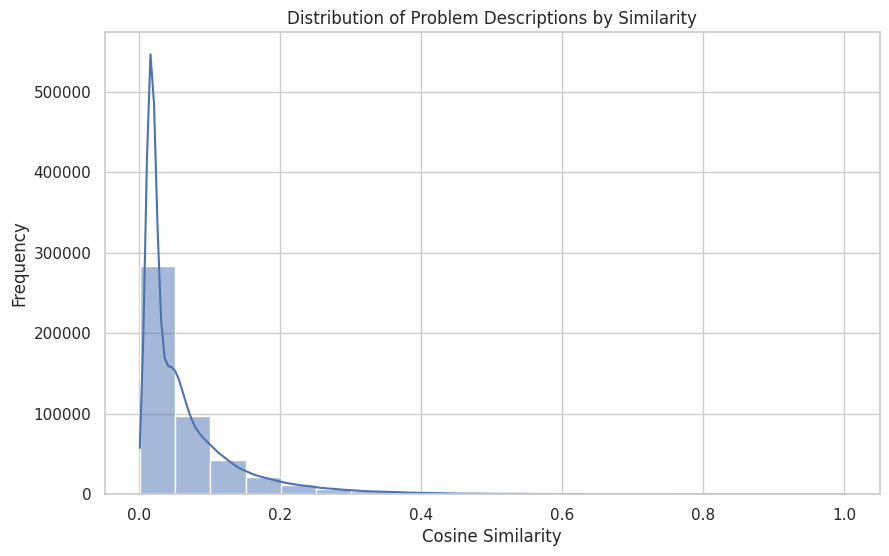

In [134]:
plt.figure(figsize=(10, 6))
sns.histplot(sim_scores, bins=20, kde=True)
plt.title('Distribution of Problem Descriptions by Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [135]:
from sklearn.decomposition import LatentDirichletAllocation

vectors = tfidf_vectors; group_num = 3 #3(연산, 자료구조, 문자열), 4, 10, 15
lda = LatentDirichletAllocation(n_components=group_num, random_state=0)
lda.fit(vectors)

LatentDirichletAllocation(n_components=3, random_state=0)

In [136]:
print(lda.components_.shape)
lda.components_

(3, 728)


array([[0.8871407 , 0.33535144, 2.08179188, ..., 0.35079624, 0.33609983,
        0.33616016],
       [0.33395665, 1.53071428, 0.33484003, ..., 3.75806098, 1.82645537,
        0.33438641],
       [0.33400083, 0.33484466, 0.34254821, ..., 0.35911852, 0.33489105,
        0.79193631]])

In [137]:
vectors.__class__, vectors.shape, vectorizer.get_feature_names_out(), len(vectorizer.get_feature_names_out())

(scipy.sparse._csr.csr_matrix,
 (974, 728),
 array(['def', 'else', 'false', 'february', 'return', 'true'], dtype=object),
 6)

In [138]:
def display_topic_words(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('\nTopic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환.
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]

        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' + '.join([str(feature_names[i])+'*'+str(round(topic[i],1)) for i in top_indexes])
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
vectors = vectorizer.fit_transform(df['text'])
feature_names = vectorizer.get_feature_names_out()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topic_words(lda, feature_names, 15)



Topic # 0
string*22.4 + remove*14.5 + character*13.4 + function*12.8 + write*12.6 + regex*12.2 + using*11.1 + area*10.2 + word*9.9 + find*8.9 + letter*7.5 + given*6.7 + substring*5.8 + surface*5.8 + volume*5.1

Topic # 1
function*43.5 + write*42.1 + given*39.7 + list*37.7 + tuple*34.2 + find*32.9 + element*28.6 + array*24.7 + python*20.5 + tuples*19.7 + maximum*19.7 + two*19.2 + number*18.5 + sort*15.0 + value*14.4

Topic # 2
number*51.0 + python*43.8 + function*38.5 + write*37.3 + find*30.5 + given*30.2 + check*30.0 + list*28.6 + whether*25.4 + sum*23.6 + first*19.6 + odd*16.3 + even*16.3 + count*14.4 + nth*13.9


In [139]:
doc_topics = lda.transform(count_vectors)
print(doc_topics.shape)
print(doc_topics[:3])

(974, 3)
[[0.02162441 0.95313843 0.02523716]
 [0.03457371 0.92812726 0.03729903]
 [0.41808237 0.05407022 0.52784741]]


In [140]:
topic_names = ['Topic #'+ str(i) for i in range(0, group_num)]
doc_topic_df = pd.DataFrame(data=doc_topics, columns=topic_names, index=df.task_id)
doc_topic_df.head(20)
doc_topic_df['Topic Max'] = doc_topic_df.idxmax(axis=1)
doc_topic_df.head(20)

,Topic #0,Topic #1,Topic #2,Topic Max
task_id,,,,
1,0.021624,0.953138,0.025237,Topic #1
2,0.034574,0.928127,0.037299,Topic #1
3,0.418082,0.054070,0.527847,Topic #2
4,0.027213,0.943041,0.029746,Topic #1
5,0.026841,0.939738,0.033421,Topic #1
6,0.029158,0.539455,0.431388,Topic #1
7,0.932346,0.033493,0.034162,Topic #0
8,0.034577,0.040827,0.924597,Topic #2
9,0.033222,0.037502,0.929276,Topic #2


In [141]:
doc_topic_df['Topic Max'].value_counts()

,count
Topic Max,
Topic #1,446
Topic #2,424
Topic #0,104


##### sklearn.datasets.fetch_20newsgroups

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 등 8개 주제를 추출.
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med'  ]

# 위에서 cats 변수로 기재된 category만 추출. featch_20newsgroups( )의 categories에 cats 입력
news_df= fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'),
                            categories=cats, random_state=0)
news_df.keys()

In [41]:
def get_filename_list(newsdata):
    filename_list=[]

    for file in newsdata.filenames:
            #print(file)
            filename_temp = file.split('\\')[-2:]
            filename = '.'.join(filename_temp)
            filename_list.append(filename)

    return filename_list

filename_list = get_filename_list(news_df)
print("filename 개수:",len(filename_list), "filename list 10개만:",filename_list[:10])



NameError: name 'news_df' is not defined

## Common keywords in code solutions

In [192]:
import nltk, string
nltk.download('punkt_tab'); nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

#tokenizer = RegexpTokenizer("\W+", gaps=True)
english_stops = set(stopwords.words('english'))

tf = df.copy()
#tf['tokenized'] = df['code'].apply(lambda x: [tokenizer.tokenize(doc) for doc in x])
tf['tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['code']), axis=1)
tf['tokenized'] = tf['tokenized'].apply(lambda x: [char for char in x if char not in string.punctuation])
#tf['tokenized'] = df['code'].apply(lambda x: [word for word in x if word.lower() not in english_stops and len(word)>1])
tf['stop_words'] = tf['tokenized'].apply(lambda x: [word for word in x if word.lower() not in english_stops])


def my_tokenizer(docs):
    token_docs = docs.apply(lambda x: [nltk.word_tokenize(word) for word in x])
    #my_pos = [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective']]
    #return [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective'] and len(token)>1]
    return token_docs.apply(lambda x: [word for word in x if word.lower() not in english_stops])

def my_tokenizer(doc):
    token = nltk.word_tokenize(doc)
    token = [char for char in token if char not in string.punctuation]
    #my_pos = [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective']]
    #return [token for token, pos in doc if pos in ['Noun', 'Verb', 'Adjective'] and len(token)>1]
    return [word for word in token if word.lower() not in english_stops]
    #return [word for word in token if word.lower() not in english_stops and len(word)>1]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [193]:
from nltk import FreqDist
from nltk.util import ngrams

def get_frequent_ngram(corpus, ngram, n=20):
    """Find most common n n-grams tokens."""
    # Preprocess each document
    documents = [my_tokenizer(document) for document in corpus]
    #documents = [document for document in corpus]

    # Find ngrams per document
    n_grams = [list(ngrams(document, ngram)) for document in documents]

    # Find frequency of ngrams
    n_grams_flattened = [item for sublist in n_grams for item in sublist]
    freq_dist = FreqDist(n_grams_flattened)
    top_freq = freq_dist.most_common(n)
    ngram_df = pd.DataFrame(top_freq, columns=["ngram", "count"])
    ngram_df['ngram']=ngram_df['ngram'].astype(str)
    #ngram_df["col"] = str(ngram)
    return ngram_df# Get frequent ngrams for all 4

'''
ngrams_df = DataFrame()
for i in range(1,5):
  ngrams_df = pd.concat([ngrams_df, get_frequent_ngram(csv_df['Article'], i)])
'''

"\nngrams_df = DataFrame()\nfor i in range(1,5):\n  ngrams_df = pd.concat([ngrams_df, get_frequent_ngram(csv_df['Article'], i)])\n"

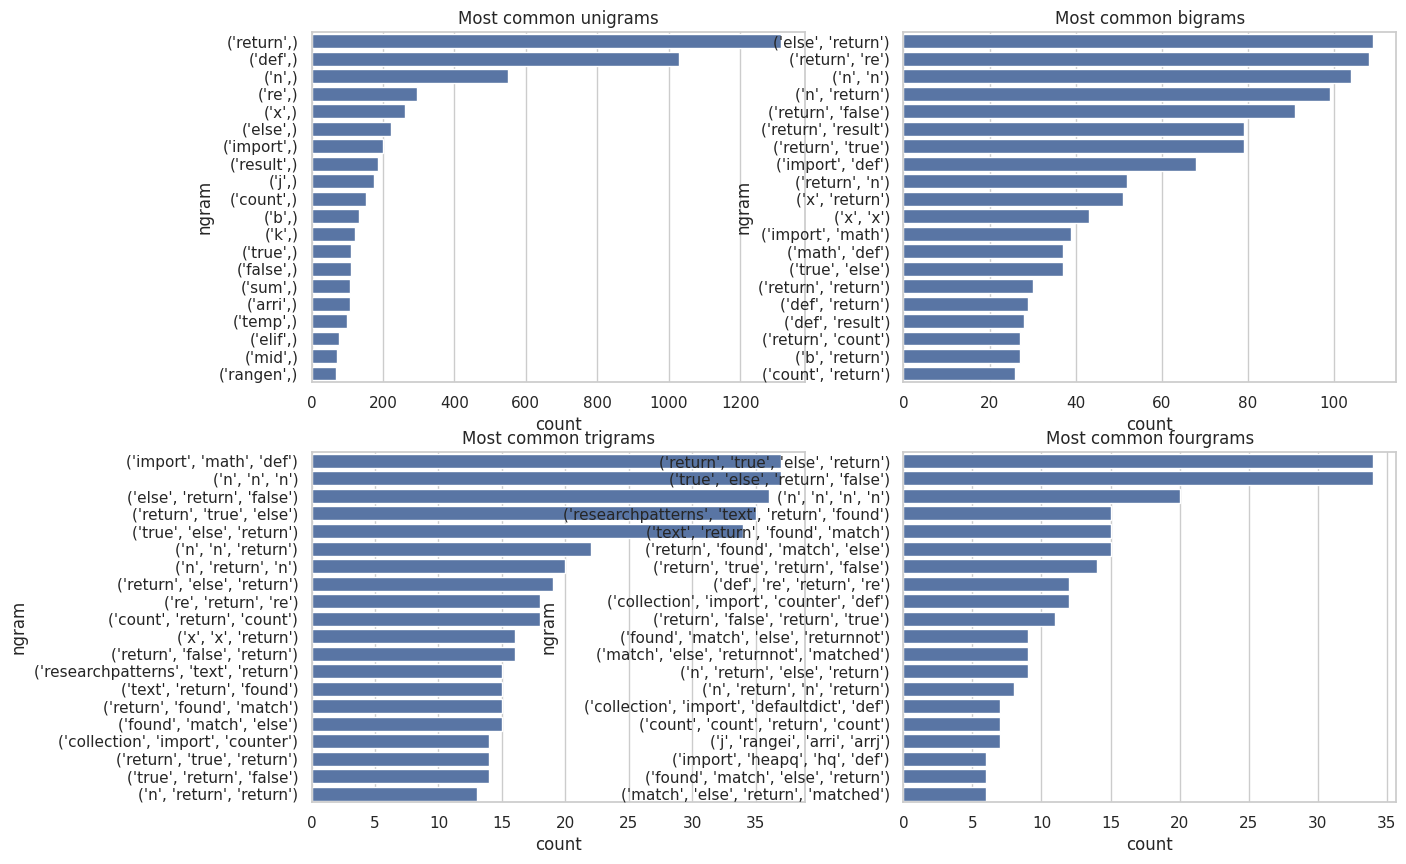

In [81]:
#plt.rcParams['font.family'] = 'NanumGothic'

fig, ax = plt.subplots(2,2, figsize=(14, 10))
mapping = {1:"uni", 2:"bi", 3:"tri", 4:"four"}
#sns.set_color_codes('pastel')
#sns.set_color_codes('muted')

for i in range(1,5):
    b = str(format(i-1,'b'))
    if len(b)<2:
        b='0'+b
    #ndf = get_frequent_ngram(tf['stop_words'], i)
    ndf = get_frequent_ngram(df['code'], i)
    sns.set_theme(style="whitegrid") ## figure, axes 스타일
    sns.barplot(x=ndf['count'], y=ndf['ngram'], ax=ax[int(b[0]), int(b[1])]).set(title=f"Most common {mapping[i]}grams")
    #sns.barplot(palette='Blues_r', edgecolor='w', x="count", y="ngram", data=get_frequent_ngram(csv_df['Article'], i), ax=ax[int(b[0]), int(b[1])]).set(title=f"Most common {mapping[i]}grams")
    plt.title(f"Most common {mapping[i]}grams")
#plt.savefig('article_ngram_token_pos.png')  # 필요한 경우, 그래프를 이미지 파일로 저장한다.
plt.show()

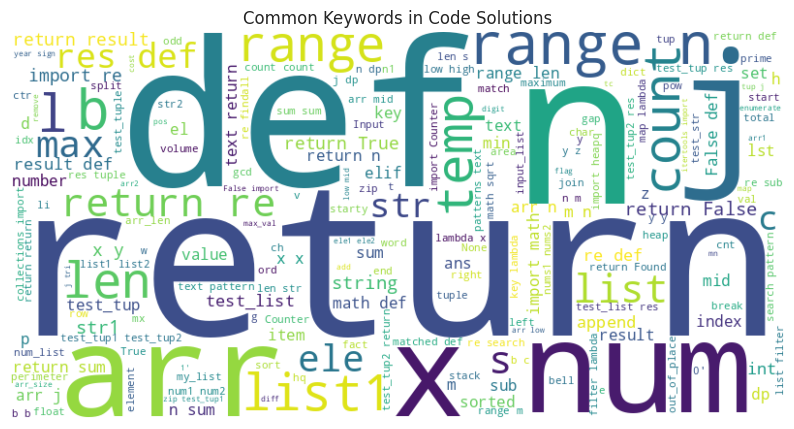

In [82]:
code_text = " ".join(df['code'])
code_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(code_text)
plt.figure(figsize=(10, 6))
plt.imshow(code_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Keywords in Code Solutions')
plt.show()

In [142]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# CountVectorizer를 사용하여 벡터화
#count_vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english')
count_vectorizer = CountVectorizer(tokenizer=LemNormalize, token_pattern=None)
count_vectors = count_vectorizer.fit_transform(df['code'])

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer(tokenizer=LemNormalize, token_pattern=None)
tfidf_vectors = tfidf_vectorizer.fit_transform(df['code'])

# 코사인 유사도 계산
cosine_sim_count = cosine_similarity(count_vectors, count_vectors)
cosine_sim_tfidf = cosine_similarity(tfidf_vectors, tfidf_vectors)

print("CountVectorizer를 사용한 코사인 유사도:", cosine_sim_count.shape)
print(cosine_sim_count)
print("\nTF-IDF를 사용한 코사인 유사도:", cosine_sim_tfidf.shape)
print(cosine_sim_tfidf)

CountVectorizer를 사용한 코사인 유사도: (974, 974)
[[1.         0.18257419 0.16269784 ... 0.18257419 0.15811388 0.2331262 ]
 [0.18257419 1.         0.19802951 ... 1.         0.28867513 0.17025131]
 [0.16269784 0.19802951 1.         ... 0.19802951 0.17149859 0.15171652]
 ...
 [0.18257419 1.         0.19802951 ... 1.         0.28867513 0.17025131]
 [0.15811388 0.28867513 0.17149859 ... 0.28867513 1.         0.14744196]
 [0.2331262  0.17025131 0.15171652 ... 0.17025131 0.14744196 1.        ]]

TF-IDF를 사용한 코사인 유사도: (974, 974)
[[1.         0.01469147 0.02532016 ... 0.01469147 0.00566296 0.04647541]
 [0.01469147 1.         0.02227947 ... 1.         0.01978422 0.01091288]
 [0.02532016 0.02227947 1.         ... 0.02227947 0.00858782 0.01880791]
 ...
 [0.01469147 1.         0.02227947 ... 1.         0.01978422 0.01091288]
 [0.00566296 0.01978422 0.00858782 ... 0.01978422 1.         0.00420647]
 [0.04647541 0.01091288 0.01880791 ... 0.01091288 0.00420647 1.        ]]


In [143]:
# 가장 유사한 문장의 인덱스 찾기
import numpy as np
threshold = 1.0000; top_k=30

# Set diagonal elements to -1 to exclude self-similarity
cosine_sim = cosine_sim_tfidf
np.fill_diagonal(cosine_sim, -1)
'''
print(cosine_sim_count[cosine_sim_count >= threshold].shape)
for i in range(cosine_sim_count.shape[0]):
    for j in range(cosine_sim_count.shape[1]):
        if cosine_sim_count[i, j] >= threshold:
            print(i, j, cosine_sim_count[i, j])
#cosine_sim_count[cosine_sim_count >= threshold] = -1
'''

# Find the indices of the maximum similarity
# np.unravel_index converts a flat index to a multi-dimensional index
max_indices = np.unravel_index(np.argmax(cosine_sim), cosine_sim.shape)
i, j = max_indices

print(f"가장 유사한 두 벡터의 인덱스: {i}, {j}")
print(f"해당 벡터: {df['code'][i]}, {df['code'][j]}")
print(f"코사인 유사도: {cosine_sim[i, j]:.4f}")

가장 유사한 두 벡터의 인덱스: 281, 357
해당 벡터: def sub_list(nums1,nums2):
  result = map(lambda x, y: x - y, nums1, nums2)
  return list(result), def moddiv_list(nums1,nums2):
  result = map(lambda x, y: x % y, nums1, nums2)
  return list(result)
코사인 유사도: 1.0000


In [144]:
# 상삼각행렬(중복 제거)만 추출
triu_indices = np.triu_indices_from(cosine_sim, k=1)
sim_scores = cosine_sim[triu_indices]

# threshold 이상인 쌍의 인덱스와 유사도 추출
valid_indices = np.where(sim_scores > -1)[0]
print((974*974-974)/2, valid_indices.shape)

# 유사도 내림차순 정렬 후 top-k 추출
sorted_idx = valid_indices[np.argsort(sim_scores[valid_indices])[::-1]]
top_k_idx = sorted_idx[:top_k]

vectorizer = tfidf_vectorizer
print(f"Top-{top_k} 유사도 쌍 (threshold={threshold}):")
for rank, idx in enumerate(top_k_idx, 1):
    i = triu_indices[0][idx]
    j = triu_indices[1][idx]
    print(f"{rank}. 인덱스: ({i}, {j}), 유사도: {cosine_sim[i, j]:.4f}, 벡터: {df['code'][i]}, {df['code'][j]}")
    print(f" 유사도: {cosine_similarity(vectorizer.fit_transform(df['text'][[i,j]])[0], vectorizer.fit_transform(df['text'][[i,j]])[1])}, 설명: {df['text'][i]}, {df['text'][j]}")


473851.0 (473851,)
Top-30 유사도 쌍 (threshold=1.0):
1. 인덱스: (617, 681), 유사도: 1.0000, 벡터: def div_list(nums1,nums2):
  result = map(lambda x, y: x / y, nums1, nums2)
  return list(result), def mul_list(nums1,nums2):
  result = map(lambda x, y: x * y, nums1, nums2)
  return list(result)
 유사도: [[0.83504991]], 설명: Write a function to divide two lists using map and lambda function., Write a function to multiply two lists using map and lambda function.
2. 인덱스: (617, 728), 유사도: 1.0000, 벡터: def div_list(nums1,nums2):
  result = map(lambda x, y: x / y, nums1, nums2)
  return list(result), def add_list(nums1,nums2):
  result = map(lambda x, y: x + y, nums1, nums2)
  return list(result)
 유사도: [[0.83504991]], 설명: Write a function to divide two lists using map and lambda function., Write a function to add two lists using map and lambda function.
3. 인덱스: (444, 887), 유사도: 1.0000, 벡터: def index_multiplication(test_tup1, test_tup2):
  res = tuple(tuple(a * b for a, b in zip(tup1, tup2))
   for tup1, tup2 

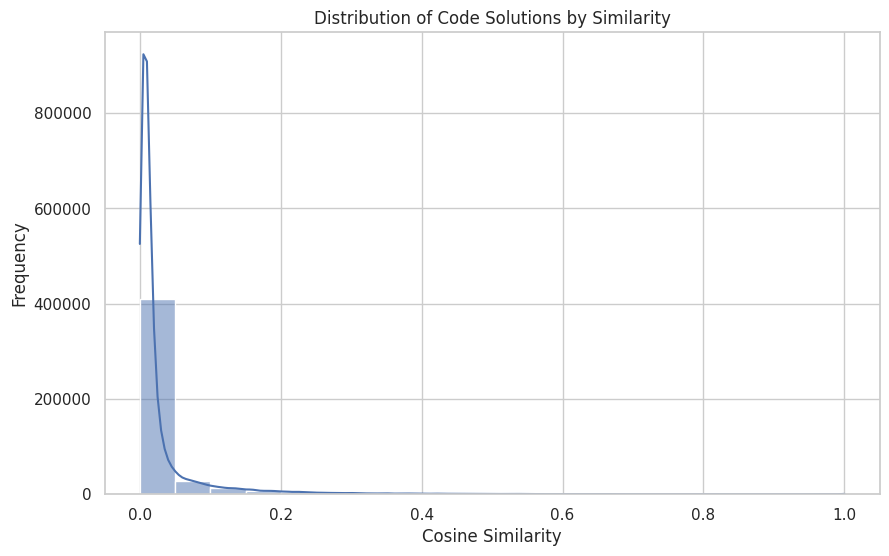

In [145]:
plt.figure(figsize=(10, 6))
sns.histplot(sim_scores, bins=20, kde=True)
plt.title('Distribution of Code Solutions by Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [163]:
from sklearn.decomposition import LatentDirichletAllocation

vectors = tfidf_vectors; group_num = 4 #3(연산, 자료구조, 문자열), 4, 5, 10, 15
lda = LatentDirichletAllocation(n_components=group_num, random_state=0)
lda.fit(vectors)

LatentDirichletAllocation(n_components=4, random_state=0)

In [164]:
print(lda.components_.shape)
lda.components_

(4, 2473)


array([[0.25010779, 0.25558392, 0.25024302, ..., 0.47610264, 0.47610264,
        0.25016136],
       [0.25010895, 0.25019777, 0.25037089, ..., 0.25019523, 0.25019523,
        0.25014916],
       [0.25014058, 0.54558415, 0.25028219, ..., 0.25023601, 0.25023601,
        0.25018839],
       [2.83786709, 0.25016069, 0.41504337, ..., 0.25013312, 0.25013312,
        1.19155015]])

In [165]:
def display_topic_words(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('\nTopic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환.
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]

        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' + '.join([str(feature_names[i])+'*'+str(round(topic[i],1)) for i in top_indexes])
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
vectors = vectorizer.fit_transform(df['code'])
feature_names = vectorizer.get_feature_names_out()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topic_words(lda, feature_names, 15)



Topic # 0
return*33.1 + def*25.3 + n*24.5 + sum*19.8 + false*13.6 + import*12.0 + true*11.8 + else*11.8 + total*8.5 + j*8.3 + x*7.4 + b*7.2 + temp*6.3 + num*5.8 + p*5.5

Topic # 1
result*43.1 + return*19.3 + x*18.6 + def*16.0 + n*14.3 + import*8.0 + l*6.0 + j*5.6 + else*5.3 + key*5.2 + mid*4.8 + elif*4.4 + ctr*4.1 + listresult*4.0 + itertools*3.9

Topic # 2
x*6.7 + return*6.3 + def*5.7 + el*5.0 + nextel*3.4 + list*3.2 + num*3.2 + ifi*2.6 + mid*2.3 + right*2.3 + left*2.2 + firsteven*2.2 + firstodd*2.2 + n*2.1 + import*2.0

Topic # 3
re*55.8 + count*27.7 + return*26.2 + def*22.0 + n*18.2 + b*15.4 + ele*13.8 + k*12.7 + else*11.2 + import*10.6 + temp*10.0 + j*9.1 + testlist*9.0 + r*8.7 + x*8.5


In [166]:
doc_topics = lda.transform(vectors)
print(doc_topics.shape)
print(doc_topics[:3])

(974, 4)
[[0.05768384 0.76392245 0.05663221 0.1217615 ]
 [0.11190407 0.11074125 0.1096972  0.66765748]
 [0.08770219 0.76176088 0.07343925 0.07709768]]


In [167]:
topic_names = ['Topic #'+ str(i) for i in range(0, group_num)]
doc_topic_df = pd.DataFrame(data=doc_topics, columns=topic_names, index=df.task_id)
doc_topic_df.head(20)
doc_topic_df['Topic Max'] = doc_topic_df.idxmax(axis=1)
doc_topic_df.head(20)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic Max
task_id,,,,,
1,0.057684,0.763922,0.056632,0.121762,Topic #1
2,0.111904,0.110741,0.109697,0.667657,Topic #3
3,0.087702,0.761761,0.073439,0.077098,Topic #1
4,0.777585,0.074655,0.073695,0.074065,Topic #0
5,0.096854,0.090453,0.713157,0.099536,Topic #2
6,0.783805,0.073093,0.071241,0.071861,Topic #0
7,0.093063,0.091722,0.089730,0.725485,Topic #3
8,0.747057,0.084629,0.086715,0.081599,Topic #0
9,0.074547,0.072367,0.071652,0.781434,Topic #3


In [168]:
doc_topic_df['Topic Max'].value_counts()

,count
Topic Max,
Topic #3,348
Topic #0,275
Topic #1,240
Topic #2,111


## Code complexity analysis

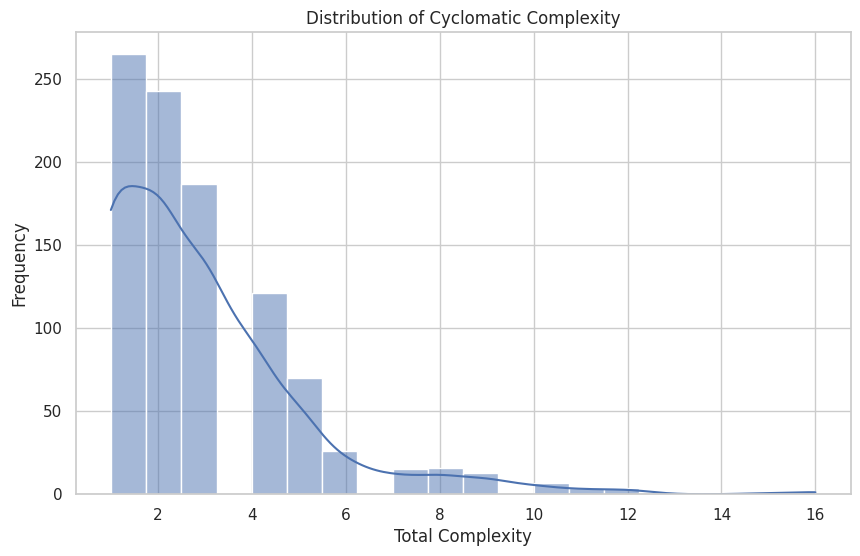

In [87]:
df['cyclomatic_complexity'] = df['code'].apply(lambda x: complexity.cc_visit(x))
#df['lines_of_code'] = df['code'].apply(lambda x: len(x.split('\n')))
df['total_complexity'] = df['cyclomatic_complexity'].apply(lambda x: sum(item.complexity for item in x))
plt.figure(figsize=(10, 6))
sns.histplot(df['total_complexity'], bins=20, kde=True)
plt.title('Distribution of Cyclomatic Complexity')
plt.xlabel('Total Complexity')
plt.ylabel('Frequency')
plt.show()

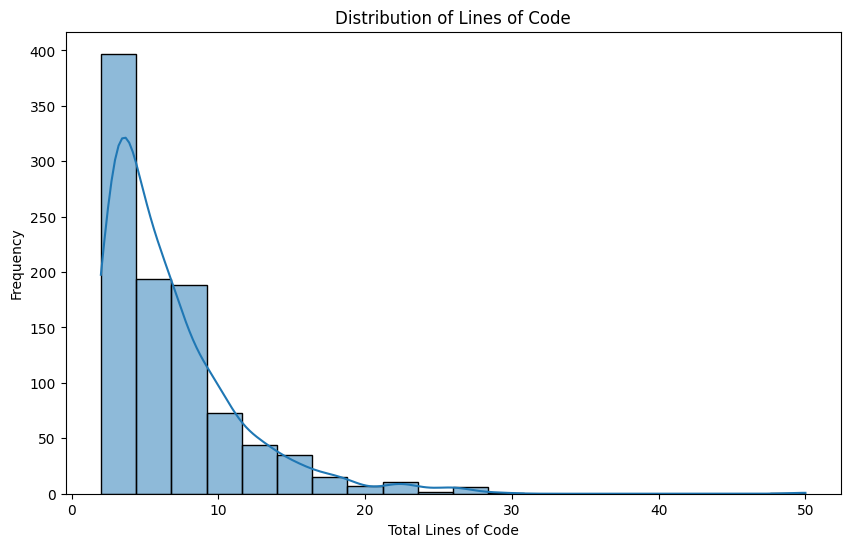

In [15]:
df['lines_of_code'] = df['code'].apply(lambda x: len(x.split('\n')))
plt.figure(figsize=(10, 6))
sns.histplot(df['lines_of_code'], bins=20, kde=True)
plt.title('Distribution of Lines of Code')
plt.xlabel('Total Lines of Code')
plt.ylabel('Frequency')
plt.show()

## Test case analysis

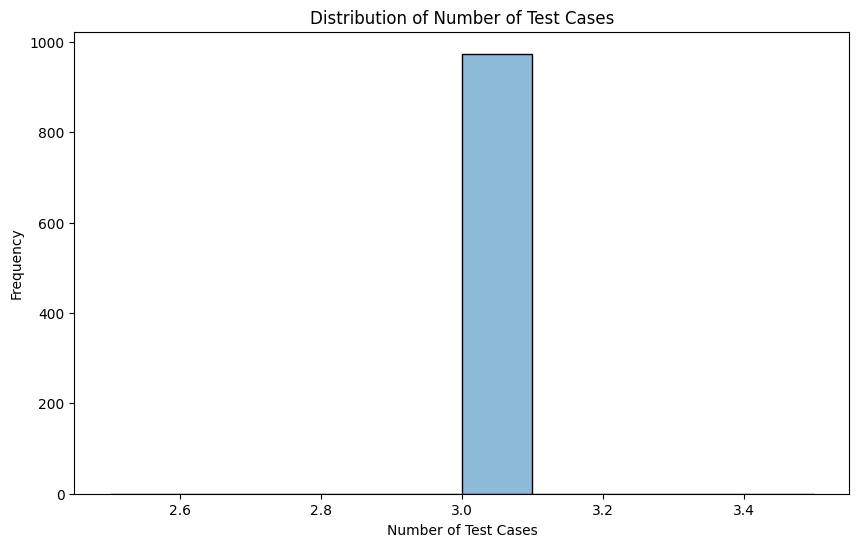

In [7]:
df['num_test_cases'] = df['test_list'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['num_test_cases'], bins=10, kde=True)
plt.title('Distribution of Number of Test Cases')
plt.xlabel('Number of Test Cases')
plt.ylabel('Frequency')
plt.show()

## Insights extraction

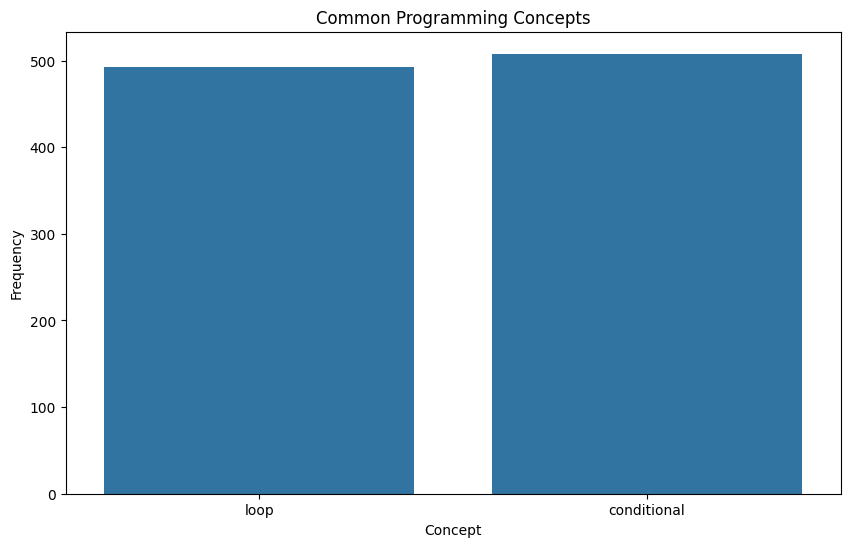

In [8]:
concepts = []
for code in df['code']:
    if 'for' in code:
        concepts.append('loop')
    if 'if' in code:
        concepts.append('conditional')
concepts_count = Counter(concepts)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(concepts_count.keys()), y=list(concepts_count.values()))
plt.title('Common Programming Concepts')
plt.xlabel('Concept')
plt.ylabel('Frequency')
plt.show()

## Clustering of tasks based on description similarity

{'write': 719, 'function': 262, 'find': 239, 'minimum': 387, 'cost': 138, 'path': 471, 'reach': 532, 'n': 404, 'given': 269, 'matrix': 377, 'position': 494, 'similar': 600, 'element': 197, 'two': 683, 'tuple': 680, 'list': 350, 'python': 518, 'identify': 289, 'nonprime': 422, 'number': 427, 'largest': 335, 'integer': 307, 'using': 697, 'heap': 278, 'queue': 520, 'algorithm': 17, 'way': 708, 'fill': 236, 'x': 720, 'domino': 189, 'board': 71, 'check': 92, 'whether': 709, 'differ': 168, 'one': 443, 'bit': 66, 'word': 718, 'least': 341, 'character': 88, 'long': 356, 'string': 633, 'regex': 544, 'square': 622, 'individual': 297, 'lambda': 334, 'rotation': 571, 'required': 559, 'get': 267, 'smallest': 607, 'item': 319, 'dataset': 149, 'remove': 547, 'first': 240, 'last': 336, 'occurrence': 437, 'sort': 612, 'ascending': 42, 'order': 448, 'according': 6, 'sum': 645, 'row': 573, 'count': 139, 'common': 114, 'dictionary': 167, 'volume': 706, 'triangular': 676, 'prism': 507, 'split': 621, 'lower

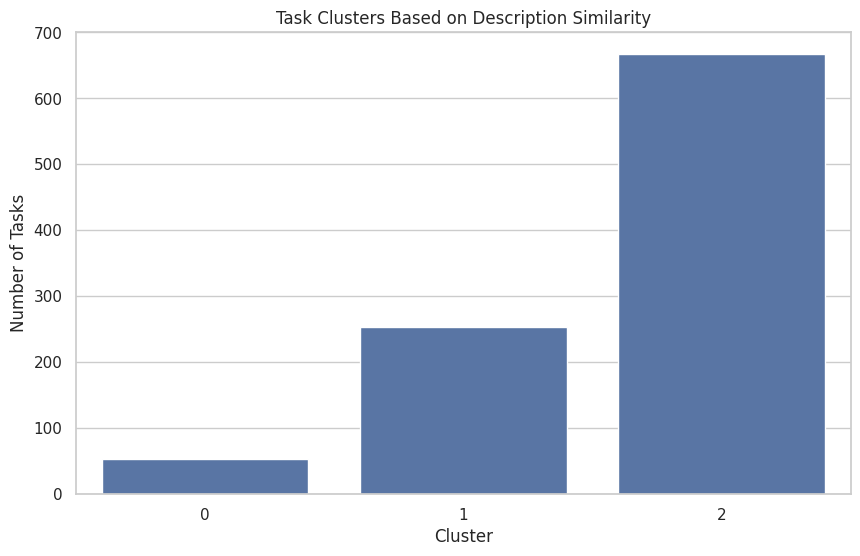

In [171]:
vectorizer = TfidfVectorizer(tokenizer=LemNormalize, token_pattern=None)
#vectorizer = CountVectorizer(tokenizer=LemNormalize, token_pattern=None)
X = vectorizer.fit_transform(df['text'])
print(vectorizer.vocabulary_)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Task Clusters Based on Description Similarity')
plt.xlabel('Cluster')
plt.ylabel('Number of Tasks')
plt.show()

In [172]:
df['cluster'].value_counts()

,count
cluster,
2,667
1,254
0,53


TODO: https://mz-moonzoo.tistory.com/23
bertopic, gptembedding + clustering(lda/kmeans)|bertopic

{'r': 1672, 'c': 177, 'def': 421, 'mincostcost': 1371, 'n': 1472, 'tc': 2236, 'x': 2439, 'rangec': 1681, 'ranger': 1720, 'j': 969, 'tcij': 2237, 'costij': 306, 'return': 1865, 'tcmn': 2238, 're': 1732, 'import': 860, 'math': 1215, 'isnotprimen': 933, 'result': 1846, 'false': 588, 'true': 2330, 'heapq': 798, 'hq': 820, 'heapqueuelargestnumsn': 810, 'largestnums': 1011, 'hqnlargestn': 828, 'nums': 1542, 'countwaysn': 373, 'b': 135, 'ai': 28, 'bi': 145, 'ispoweroftwo': 943, 'notx': 1522, 'differatonebitposab': 461, 'ispoweroftwoa': 944, 'findcharlongtext': 606, 'text': 2279, 'squarenumsnums': 2058, 'squarenums': 2057, 'listmaplambda': 1141, 'findrotationsstr': 666, 'tmp': 2300, 'str': 2081, 'lenstr': 1105, 'substring': 2133, 'tmpi': 2301, 'smallest': 1989, 'removeoccsch': 1783, 'rangelens': 1704, 'si': 1981, 'ch': 187, 'break': 167, 'sortmatrixm': 2031, 'sortedm': 2018, 'keysum': 1004, 'collection': 278, 'counter': 323, 'countcommonwords': 314, 'wordcounts': 2431, 'counterwords': 329, 'to

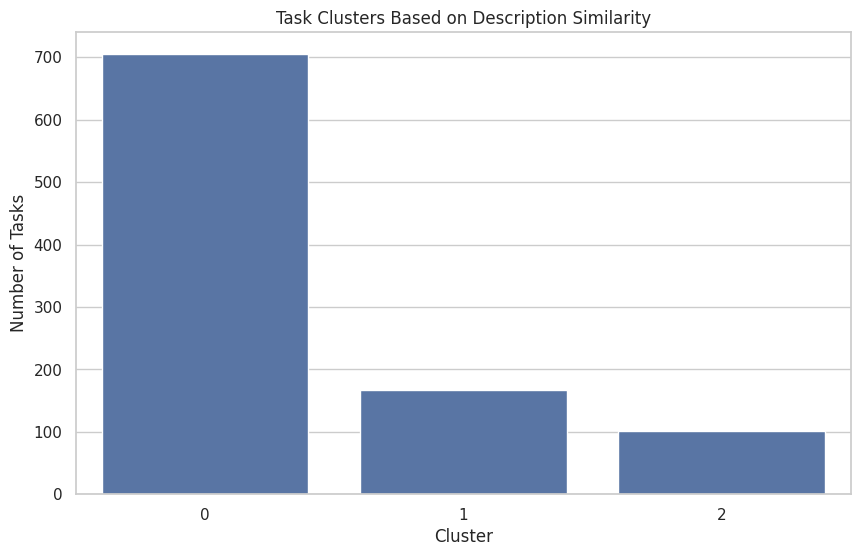

In [173]:
vectorizer = TfidfVectorizer(tokenizer=LemNormalize, token_pattern=None)
#vectorizer = CountVectorizer(tokenizer=LemNormalize, token_pattern=None)
X = vectorizer.fit_transform(df['code'])
print(vectorizer.vocabulary_)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df['cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df)
plt.title('Task Clusters Based on Description Similarity')
plt.xlabel('Cluster')
plt.ylabel('Number of Tasks')
plt.show()

In [174]:
df['cluster'].value_counts()

,count
cluster,
0,705
1,167
2,102


## Time complexity estimation

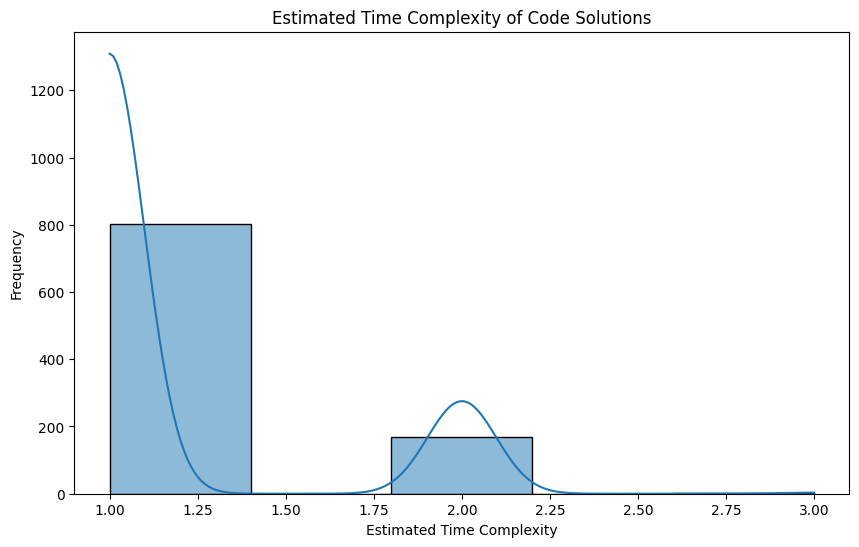

In [10]:
def estimate_time_complexity(code):
    complexity_score = 1
    if 'for' in code and 'for' in code.split('for', 1)[1]:
        complexity_score += 1
    if 'while' in code and 'while' in code.split('while', 1)[1]:
        complexity_score += 1
    if any(keyword in code for keyword in ['recursion', 'recursive', 'recur']):
        complexity_score += 2
    return complexity_score

df['estimated_time_complexity'] = df['code'].apply(estimate_time_complexity)
plt.figure(figsize=(10, 6))
sns.histplot(df['estimated_time_complexity'], bins=5, kde=True)
plt.title('Estimated Time Complexity of Code Solutions')
plt.xlabel('Estimated Time Complexity')
plt.ylabel('Frequency')
plt.show()

## Code readability and maintainability metrics

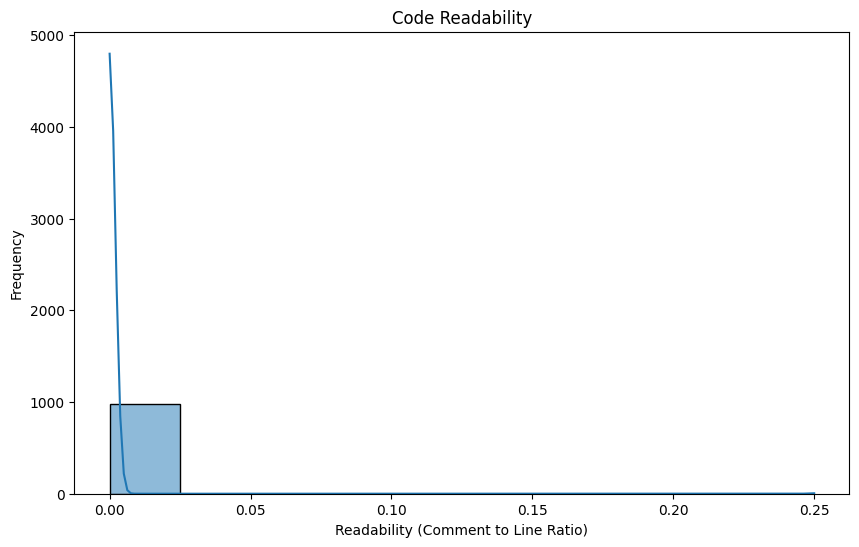

In [11]:
def calculate_readability(code):
    lines = code.split('\n')
    num_comments = sum(1 for line in lines if line.strip().startswith('#'))
    return num_comments / len(lines) if lines else 0

df['readability'] = df['code'].apply(calculate_readability)
plt.figure(figsize=(10, 6))
sns.histplot(df['readability'], bins=10, kde=True)
plt.title('Code Readability')
plt.xlabel('Readability (Comment to Line Ratio)')
plt.ylabel('Frequency')
plt.show()

### Summary of Findings:
1. The dataset contains a diverse set of problems with varying lengths of descriptions and solutions.
2. Code complexity analysis reveals a range of complexities across tasks.
3. Common programming concepts include loops and conditionals.
4. Tasks can be clustered based on description similarity, revealing potential areas of focus for learners.
5. Estimated time complexity analysis shows a majority of tasks have manageable complexity, but some are significantly more complex.
6. Code readability varies, with some solutions having higher comment-to-code ratios, indicating better documentation.

### Conclusion:
This in-depth analysis of the MBPP dataset provides valuable insights into the nature of the problems and their solutions. The analysis helps identify common programming patterns, assess solution complexity, and evaluate code quality. These insights can be used to improve the dataset, guide learners in their studies, and inform the design of future programming challenges. Potential improvements include adding more varied test cases, enhancing problem descriptions, and providing feedback on code readability.